In [3]:
import yfinance as yf
import pandas as pd
import numpy as np

import pyreadr
import os
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix,classification_report, plot_roc_curve

C:\Users\bgriffin\AppData\Local\Continuum\anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
plt.rcParams['figure.figsize'] =16,10
plt.rcParams['legend.fontsize'] =15
plt.rcParams['xtick.labelsize'] =15
plt.rcParams['ytick.labelsize'] =15
plt.rcParams['axes.labelsize'] =18
plt.rcParams['axes.titlesize'] =20

# Ichimoku Cloud
Determines if stock prices are rising from bull market or not

1. Never buy/sell in Kumo Cloud
2. If Conversion Line average crosses above Baseline and is above kumo cloud,strong buy
3. If Conversion Line averages crosses above Baseline and is below kumo cloud, weak buy
4. If Conversion Line average crosses below Baseline and is below kumo cloud,strong sell
5. If Conversion Line averages crosses below Baseline and is above kumo cloud, weak sell

In [61]:
def plot_cloud(df,ticker):
    fig, ax = plt.subplots()
    plt.plot(df['Close'], color='black',linewidth=2)
    plt.plot(df['CL'],color='blue',linewidth=2)
    plt.plot(df['Baseline'],color='orange',linewidth=2)
    plt.plot(df['LeadingSpanA'], color='green',linewidth=2)
    plt.plot(df['LeadingSpanB'], color='red',linewidth=2)
    plt.plot(df['LaggingSpan'], color='lavender',linewidth=2)
    uptrend = df['LeadingSpanA']>df['LeadingSpanB']
    plt.fill_between(df.index,df.loc[:,'LeadingSpanA'], 
                     df.loc[:,'LeadingSpanB'], where= uptrend,facecolor='green', alpha=0.5)
    downtrend = df['LeadingSpanA']<df['LeadingSpanB']
    plt.fill_between(df.index,df.loc[:,'LeadingSpanA'], 
                     df.loc[:,'LeadingSpanB'], where = downtrend,facecolor='red', alpha=0.5)
    YMIN,YMAX = df['Close'].min(),df['Close'].max()
    print(df.loc[df['Position']=='Buy'].index)
    plt.vlines(df.loc[df['Position']=='Buy'].index,YMIN,YMAX,linestyles='dashed',linewidth=4,color='lightgreen',label='Buy')
    plt.vlines(df.loc[df['Position']=='Sell'].index,YMIN,YMAX,linestyles='dashed',linewidth=4,color='lightsalmon',label='Sell')
    plt.legend()
    plt.title(f"{ticker} Ichimoku Cloud")
    plt.ylabel("Prices")
    plt.xlabel("Date")
    
    plt.show()

In [142]:
def calculate_ichimoku_cloud(df,ticker,short_period=7,long_period=26):
    max_date=df.index.max()
    present_range_begin= max_date-pd.to_timedelta(short_period,unit='D')
    past_range_end =max_date-pd.to_timedelta(long_period,unit='D')
    past_range_begin =max_date-pd.to_timedelta(long_period+short_period,unit='D')
    latest_price = df.loc[present_range_begin:max_date,'Close'].mean()
    pricethreeweeksago = df.loc[past_range_begin:past_range_end,'Close'].mean()
    
    roughstddev= df.loc[past_range_begin:max_date,'Close'].std()
    print(roughstddev,latest_price,pricethreeweeksago)
    if (latest_price-pricethreeweeksago)>2*roughstddev:
        price_trend = 'Rising'
    elif (latest_price-pricethreeweeksago)<(-2*roughstddev):
        price_trend ='Falling'
    else:
        price_trend ='Flat'
    df = df.copy()
    df[f'PH{short_period}'] = df['High'].rolling(short_period,min_periods=3).max()
    df[f'PL{short_period}'] = df['Low'].rolling(short_period,min_periods=3).min()
    df[f'PH{long_period}'] = df['High'].rolling(long_period,min_periods=3).max()
    df[f'PL{long_period}'] = df['Low'].rolling(long_period,min_periods=3).min()
    df['PH52'] = df['High'].rolling(52,min_periods=8).max()
    df['PL52'] = df['Low'].rolling(52,min_periods=8).min()
    df['CL'] = (df[f'PH{short_period}']+df[f'PL{short_period}'])/2
    df['Baseline'] = (df[f'PH{long_period}']+df[f'PL{long_period}'])/2
    dr = pd.date_range(df.index.max(),df.index.max()+pd.to_timedelta(37,unit='D'))
    indices = sorted(list(set(list(df.index) + [d for d in dr if d.weekday()<5])))
    
    df = df.reindex(indices)
    df['LaggingSpan'] = df['Close'].shift(-long_period)
    df['LeadingSpanA'] = ((df['CL'] +df['Baseline'])/2)
    df['LeadingSpanB'] = ((df['PH52'] +df['PL52'])/2)
    df['LeadingSpanA'] = df['LeadingSpanA'].shift(long_period)
    df['LeadingSpanB'] = df['LeadingSpanB'].shift(long_period)
    diffCLBL = df['CL']-df['Baseline']
    df['Position'] = np.select([((diffCLBL  < 0) & (diffCLBL.shift() > 0) & 
                                 (df['Close']<df[['LeadingSpanA','LeadingSpanB']].min(axis=1)) &
                                 ((df['Close']/df['Close'].shift(26))<1.0)), 
                                ((diffCLBL  > 0) & (diffCLBL.shift() < 0) & 
                                 (df['Close']>df[['LeadingSpanA','LeadingSpanB']].max(axis=1)) &
                                 ((df['Close']/df['Close'].shift(26))>1.0))], ['Sell', 'Buy'], None)
    
    if all(df['LeadingSpanA'].iloc[-(long_period-1):]>df['LeadingSpanB'].iloc[-(long_period-1):]):
        cloud='Support'
    elif all(df['LeadingSpanA'].iloc[-(long_period-1):]>df['LeadingSpanB'].iloc[-(long_period-1):]):
        cloud='Resistance'
    else:
        cloud='Inconclusive'
    if price_trend=='Rising' and cloud=='Support':
        market='Bull'
    elif price_trend=='Falling' and cloud=='Resistance':
        market='Bear'
    else:
        market='Inconclusive'
    print(price_trend,cloud,market)
    plot_cloud(df.loc[pd.Timestamp(2017,1,1):],ticker)
    return df,(price_trend,cloud,market)

In [143]:
def calculate_earnings(df,start_date,cash_available = 10000,stock_unit=10):
    df = df.loc[start_date:]
    most_cash_invested = 0
    cash_invested = 0
    num_stocks = 0
    for date in df.loc[~df['Position'].isna()].index:
        amount = df.loc[date,'Close']*stock_unit
        if (df.loc[date,'Position']=='Buy'):
            if (amount>cash_available):
                print('Need More Money!!')
                continue
            cash_available-=amount
            cash_invested+=amount
            most_cash_invested = max(cash_invested,most_cash_invested)
            num_stocks +=stock_unit
        if (df.loc[date,'Position']=='Sell') & (num_stocks>=stock_unit):
            cash_available+=amount
            cash_invested-=amount
            num_stocks -=stock_unit
    first_price = df.loc[start_date,'Close']
    last_price = df.loc[df['Close'].notna(),'Close'].iloc[-1]
    average_stock_price = most_cash_invested/num_stocks
    
    return cash_available,num_stocks*last_price,num_stocks,first_price,last_price,average_stock_price

# Bollinger Bands

In [144]:
def plot_bands(df,ticker):
    YMIN,YMAX = df['LB'].min(),df['UB'].max()
    fig,ax =plt.subplots()
    plt.plot(df['Close'],linewidth=2,color='navy')
    plt.plot(df['UB'],linewidth=2,color='navy',alpha=.5)
    plt.plot(df['LB'],linewidth=2,color='navy',alpha=.5)
    plt.vlines(df.loc[df['Position']=='Buy'].index,YMIN,YMAX,linestyles='dashed',linewidth=4,color='lightgreen',label='Buy')
    plt.vlines(df.loc[df['Position']=='Sell'].index,YMIN,YMAX,linestyles='dashed',linewidth=4,color='lightsalmon',label='Sell')
    plt.legend()
    plt.title(f"{ticker} Bollinger Bands")
    plt.ylabel("Prices")
    plt.xlabel("Date")
    plt.show()

In [151]:
def calculate_bollinger_bands(df,ticker,period=20,K=3):
    
    df['MA'] = df['Close'].rolling(period,min_periods=3).mean()
    rolling_std = df['Close'].rolling(period,min_periods=3).std()
    df['UB'] = df['MA'] +K*rolling_std
    df['LB'] = df['MA'] -K*rolling_std
    df['Position'] = np.select([df['Close']<df['LB'], df['Close']>df['UB']], ['Buy', 'Sell'], None)
    plot_bands(df.loc[pd.Timestamp(2017,1,1):],ticker)
    return df

In [124]:
calculate_earnings(stock_df,pd.Timestamp(2017,1,3))

(433.9056396484375,
 11297.49984741211,
 50,
 58.67324447631836,
 225.9499969482422,
 191.32188720703124)

# Stochatic Oscillator and Relative Strength Indicator

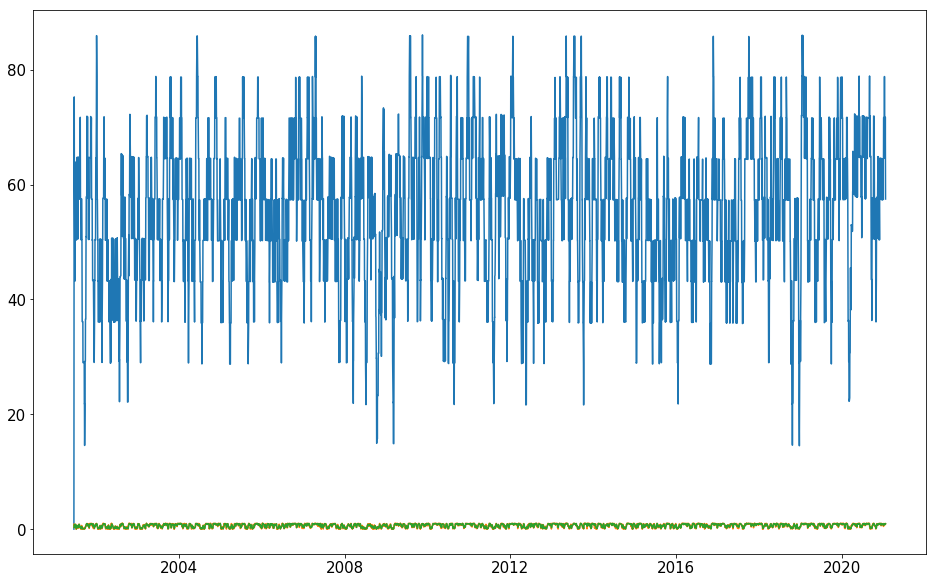

In [189]:
stock_df['RelativeStrengthIndex'] = 100-100/(1+stock_df['RelativeStrength'])
plt.plot(stock_oscillator_df['RelativeStrengthIndex'])
plt.plot(stock_oscillator_df['%K'])
plt.plot(stock_oscillator_df['%D'])

In [199]:
def plot_oscillators(df,ticker):
    fig,ax = plt.subplots()
    ax.plot(df['Close'],linewidth=2,color='navy')
    ax2=ax.twinx()
    ax2.plot(df['RelativeStrengthIndex'],linewidth=2,color='purple')
    ax2.vlines(df.loc[df['Position']=='Buy'].index,0,100,linestyles='dashed',linewidth=4,color='lightgreen',label='Buy')
    ax2.vlines(df.loc[df['Position']=='Sell'].index,0,100,linestyles='dashed',linewidth=4,color='lightsalmon',label='Sell')
    plt.legend()
    plt.title(f"{ticker} Relative Strength Index")
    ax.set_ylabel("Prices")
    ax2.set_ylabel('RSI')
    ax.set_xlabel("Date")
    plt.show()

In [161]:
(stock_df['Close']/stock_df['Close'].shift()

Date
1980-12-12         NaN
1980-12-15    0.947827
1980-12-16    0.926605
1980-12-17    1.024752
1980-12-18    1.028986
                ...   
2021-02-22         NaN
2021-02-23         NaN
2021-02-24         NaN
2021-02-25         NaN
2021-02-26         NaN
Name: Close, Length: 10138, dtype: float64

In [200]:
def calculate_oscillators(df,ticker,threshold =20,period=14):
    L14 = df['Low'].rolling(period,min_periods=3).min()
    H14 = df['High'].rolling(period,min_periods=3).max()
    df['%K'] = ((df['Close']-L14)/(H14-L14)) * 100
    df['%D'] = df['%K'].rolling(3,min_periods=1).mean()
    df['Gains'] = np.where(df['Close']>df['Close'].shift(),df['Close']/df['Close'].shift(),0)
    df['Losses'] = np.where(df['Close']<=df['Close'].shift(),df['Close']/df['Close'].shift(),0)
    df['RelativeStrength'] = df['Gains'].rolling(14,min_periods=1).mean()/df['Losses'].rolling(14,min_periods=1).mean()
    df['RelativeStrengthIndex'] = 100-100/(1+df['RelativeStrength'])
    df['Position'] = np.select([(df['RelativeStrengthIndex']<threshold),(df['RelativeStrengthIndex']>(100-threshold))],['Buy','Sell'],None)
    plot_oscillators(df.loc[pd.Timestamp(2017,1,1):],ticker)
    return df

In [201]:
ticker="AAL"
stock_info = yf.Ticker(ticker)
stock_prices = stock_info.history(period="max")

0.3756668057863483 15.910000038146972 15.78250002861023
Flat Support Inconclusive
DatetimeIndex(['2017-01-26', '2017-05-09', '2020-02-05', '2020-11-09',
               '2020-11-23'],
              dtype='datetime64[ns]', name='Date', freq=None)


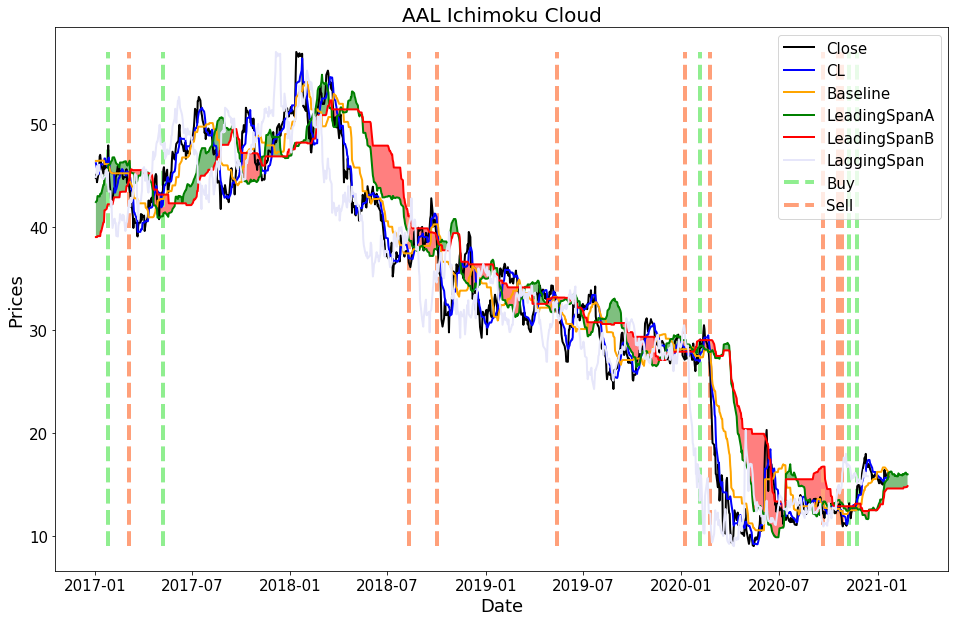

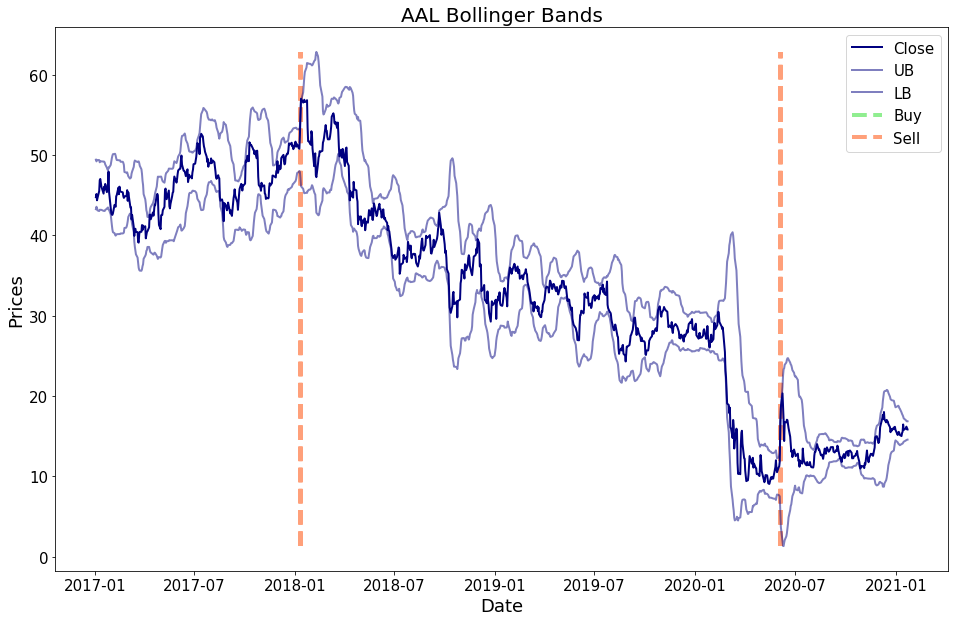

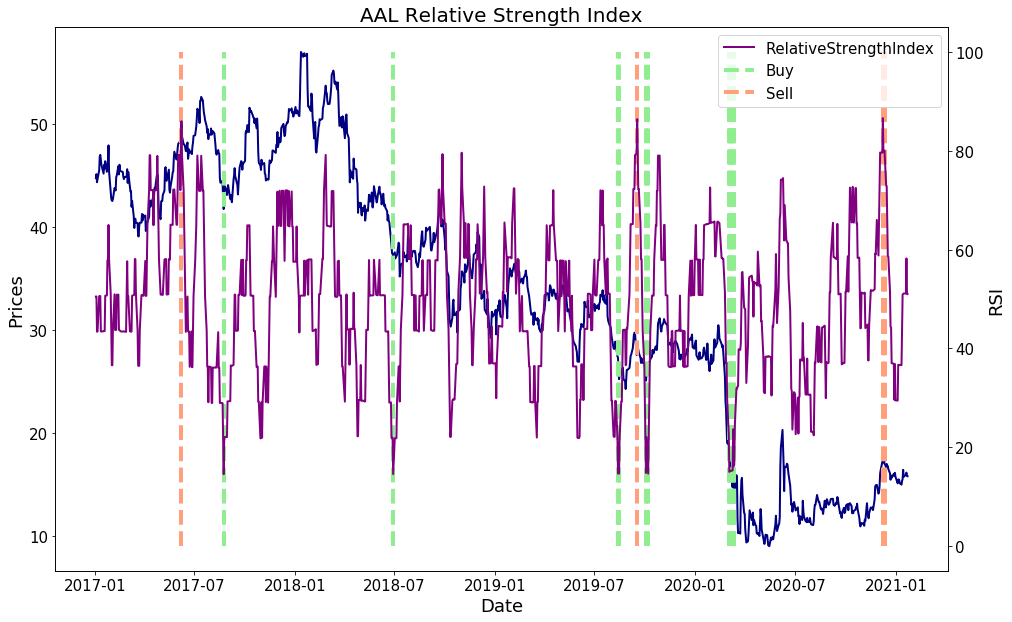

In [203]:
stock_cloud_df,(_,_,stock_market) = calculate_ichimoku_cloud(stock_prices,ticker)
stock_band_df = calculate_bollinger_bands(stock_prices,ticker)
stock_oscillator_df = calculate_oscillators(stock_prices, ticker)